In [19]:
import csv
import matplotlib.pyplot as plt

# Load CSV file
SDK_PATH = "/home/xilinx/x-heep-femu-sdk/"
RISCV_PATH = 'sw/riscv/'


energy_bd = []
time_bd = []
FILES       = [ 'perf_estim', 'energy_estim'    ]
KEYWORDS    = [ 'cycles'    , 'energy'          ]
MERGING     = [ max         , sum               ]
ORDER       = [ 1           ,  1E6              ]
UNIT        = [ 's'         , 'µJ'              ]
BREAKDOWN   = [ time_bd     , energy_bd         ]   

for filename, keyword, order, unit, op, modules in zip(FILES, KEYWORDS, ORDER, UNIT, MERGING, BREAKDOWN):
    # Open the CSV file
    with open(SDK_PATH + RISCV_PATH + 'build/'+filename+'.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)

        # Skip the header row
        header = next(reader)
        titles = header[3:-1]
        titles.append('Total')

        # Create a nested dictionary
        energy_dict = {}
        modules = []
        for row in reader: 
            try:
                (name, level) = [(row[c],c) for c in range(3) if row[c] != "" ][0]
                module = {}
                module['name'] = name
                module['level'] = level
                for t, v in zip(titles, row[3:]):
                    module[t] = v
                modules.append(module)
            except IndexError:
                pass

    stack = []

    for current_dict in modules:
        current_level = current_dict["level"]

        # Pop dictionaries from the stack until reaching a lower level
        while stack and stack[-1]["level"] >= current_level:
            popped_dict = stack.pop()
            if stack:
                # Add the popped dictionary as a submodule of the previous dictionary
                stack[-1].setdefault("submodules", []).append(popped_dict)

        # Sum the values for keys containing the word "energy" for the current dictionary and its submodules
        total1  = op([float(value) for key, value in current_dict.items() if keyword in key.lower() and value != '' and value != '-']+[0]) 
        total2  = op([submodule["Total"] for submodule in current_dict.get("submodules", [])]+[0] )
        total   = op([total1,total2])
        # Update the "Total" key for the current dictionary
        current_dict["Total"] = total


        # Add the current dictionary to the stack
        stack.append(current_dict)

    # Any remaining dictionaries in the stack are top-level dictionaries
    modules.extend(stack)
    # Clean the modules to only have the top one.
    # modules = [d for d in modules if d.get("level", 0) == 0]
    modules = modules[0] # Remove the two last, unnecessary lines

    # Recursively sum the Total energy of each module
    def update_totals(node):
        # Recursively update totals starting from the lowest children
        if node.get("submodules"):
            for submodule in node["submodules"]:
                update_totals(submodule)
                node["Total"] = op([node["Total"],submodule["Total"] ])

    update_totals(modules)


    print(f"Total {keyword}: {modules['Total']*order:.2f} {unit}")

    if 0:
        import pprint
        pprint.pprint(modules)

Total energy: 307.45 µJ
Total cycles: 0.42 s
[]


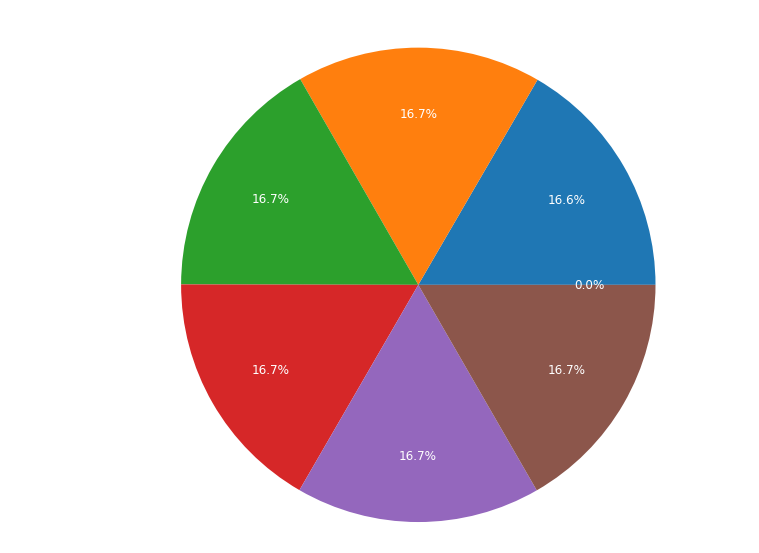

In [20]:
import numpy as np

LEVEL = 1
THRESHOLD = 0.02

def flatten_nested_dicts(nested_dict):
    # Recursively flatten a nested dictionary into a list of dictionaries
    flattened_list = [nested_dict.copy()]
    if "submodules" in nested_dict:
        for submodule in nested_dict["submodules"]:
            flattened_list.extend(flatten_nested_dicts(submodule))
    return flattened_list

# Use the flatten_nested_dicts function to get a list of all dictionaries
all_dicts_list = flatten_nested_dicts(modules)

# Only second-level modules
totals  = [d['Total']   for d in all_dicts_list if d.get("level") == LEVEL]
names   = [d['name']    for d in all_dicts_list if d.get("level") == LEVEL]


# Find indices of values less than 1%
small_values_indices = np.where(np.array(totals) / sum(totals) < THRESHOLD)[0]

# Merge small values into "others"
others_total = sum(totals[i] for i in small_values_indices)
names = [ name for i, name in enumerate(names)  if i not in small_values_indices ]
totals = [total for i, total in enumerate(totals) if i not in small_values_indices]
names.append("Others")
totals.append(others_total)

# Plotting the larger pie chart with specified colors and font settings
pie, texts, autotexts = plt.pie(totals, labels=names, autopct='%1.1f%%', startangle=0,
                                textprops={'fontsize': 12, 'color': 'white'})

for autotext in autotexts:
    autotext.set_position((1.2 * autotext.get_position()[0], 1.2 * autotext.get_position()[1]))  # Increase the radius for larger pie chart
    autotext.set_rotation(0)  # Adjust the rotation angle as needed

# Adjust the position and rotation of labels
dist = 0.95
for text in texts:
    text.set_position((dist* text.get_position()[0], dist * text.get_position()[1]))  # Increase the distance from the center
    text.set_rotation(0)  # Adjust the rotation angle as needed

plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle
plt.title('Energy breakdown', fontsize=14, color='white')

# Add some space between the pie chart and the title
plt.subplots_adjust(top=0.85)

# Set the figure size to make the pie chart larger
plt.gcf().set_size_inches(10, 10)

plt.show()